In [1]:
from __future__ import print_function

import csv
import codecs
import sys
import string
import time
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from random import shuffle 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.classify import SklearnClassifier
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA, FastICA, fastica
from sklearn import preprocessing
from sklearn import random_projection

def parseReview(line):
    if line[1] == "__label1__":
        s = 0
    else:
        s = 1
    return (line[0], line[2], line[3], line[4], line[8], s)

def preProcess(text):
    m = {key: "" for key in string.punctuation}
    #table = string.maketrans(m)
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(m)
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens
    return filtered_tokens

def loadData(path):
    rawData = []
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        categories = {}
        ind = 0
        for line in reader:
            (Id, rating, verified_purchase, product_category, text, Label) = parseReview(line)
            if product_category not in categories:
                category = ind
                categories[product_category] = ind
                ind += 1
            vp = 1 if verified_purchase == 'Y' else 0
            filtered_tokens = preProcess(unicode(text, 'utf-8'))
            # Only use text field
            #rawData.append([' '.join(filtered_tokens), Label])
            # Use all fields
            rawData.append([' '.join(filtered_tokens), len(filtered_tokens), vp, int(rating), Label])
    shuffle(rawData)
    Y = [x[-1] for x in rawData]
    support = [[x[1], x[2], x[3]] for x in rawData]
    X = [x[0] for x in rawData]
    return X, Y, support


def processData(rawData):
    X = []
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(rawData)
    X = X.toarray()
    return X
        
def crossValidate(trainData, folds, classifier):
    cv_results = []
    foldsize = int (len(trainData)//folds)
    for i in xrange(0, len(trainData), foldsize):
        pipeline = Pipeline([('', classifier)])
        clf = SklearnClassifier(pipeline).train(trainData[:i] + trainData[foldsize + i:])
        y_pred = clf.classify_many(map(lambda t : t[0], trainData[i:foldsize + i]))
        a, p, r, f = predict(trainData[i:foldsize + i], y_pred)
        cv_results.append((a, p, r, f))
    cv_results = (np.mean(np.array(cv_results), axis=0))
    return cv_results, clf

def plot_boosting_deviance(clf, params, X_test, y_test):
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
	test_score[i] = clf.loss_(y_test, y_pred)
	plt.figure()
	plt.title('Deviance')
	plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
		 label='Training Set Deviance')
	plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
		 label='Test Set Deviance')
	plt.legend(loc='upper right')
	plt.xlabel('Boosting Iterations')
	plt.ylabel('Deviance')
        fig = plt.gcf()
        fig.savefig('boosting deviance')

[nltk_data] Downloading package punkt to /home/junyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/junyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/junyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
rawData, Y, support = loadData('reviews_4000.txt')
X = processData(rawData)[:1500]
Y = np.array(Y)[:1500]
print(X.shape)
print(Y.shape)

(1500, 12688)
(1500,)


In [3]:

starttime = time.time()
rp = random_projection.GaussianRandomProjection(n_components=2)
reduced_data = rp.fit_transform(X)
reduced_data = preprocessing.scale(reduced_data)
print("RS time is ", time.time()-starttime)

RS time is  0.095990896225


In [19]:
print(reduced_data.shape)

(1000, 500)


In [4]:
newdata = []
for i in xrange(reduced_data.shape[0]):
    newdata.append(np.append(reduced_data[i], support[i]))
newdata = np.array(newdata)
newdata = preprocessing.scale(newdata)
print(newdata.shape)
print(newdata[:10])

(1500, 5)
[[ 0.06665684 -0.11180605 -0.35422508  0.91801516 -0.46657888]
 [-1.83372883 -0.4135954   0.30385966  0.91801516  1.05157365]
 [-0.76268512  0.77304466 -0.57358666 -1.08930662 -0.46657888]
 [ 1.14391138 -1.60156278 -0.3980974   0.91801516  1.05157365]
 [-1.68103791 -0.43743456 -0.04711887 -1.08930662 -0.46657888]
 [-1.93735888  1.35243822 -0.42003356  0.91801516  0.29249739]
 [-0.06357738  0.52341977 -0.44196971  0.91801516  1.05157365]
 [-0.24351743  0.51936008 -0.06905503 -1.08930662  0.29249739]
 [ 0.23684069 -0.77237746 -0.20067197 -1.08930662 -0.46657888]
 [-0.17492194  0.26513433 -0.50777819  0.91801516  1.05157365]]


In [37]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(newdata)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
predict = kmeans.labels_.astype(np.int)
precision, recall, _, _ = precision_recall_fscore_support(Y, predict, average = 'micro')
print(precision, recall)

0.474 0.474


Evaluate of KMeans with k-means++ init
running time is 0.470400810242 s


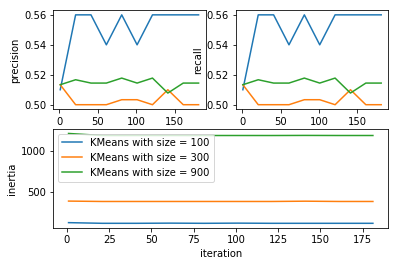

In [8]:
clusters = [
               (KMeans, 'k-means++', {}),             
           ]
sample_size = [100, 300, 900]
max_iters = xrange(1, 200, 20)
clf_error = {}
plt.figure()
ax1 = plt.subplot(212)
ax2 = plt.subplot(221)
ax3 = plt.subplot(222)
legends = []
starttime = time.time()
for factory, init, params in clusters:
    print('Evaluate of {} with {} init'.format(factory.__name__, init))
    for size in sample_size:
        precisions = np.empty(len(max_iters))
        recalls = np.empty(len(max_iters))
        inertia = np.empty(len(max_iters))
        for i, max_iter in enumerate(max_iters):
            #change fit(newdata[:size]) to use PCA
            #change to fit(X[:size]) to use kmeans without reduction
            km = factory(n_clusters=2, max_iter=max_iter, n_init=5, **params).fit(newdata[:size])
            predict = km.labels_.astype(np.int)
            precision, recall, _, _ = precision_recall_fscore_support(Y[:size], predict, average = 'micro')
            #print(precision, recall)
            inertia[i] = km.inertia_
            precisions[i] = max(precision, 1 - precision)
            recalls[i] = max(recall, 1 - recall)
        ax1.plot(max_iters, inertia)
        ax2.plot(max_iters, precisions)
        ax3.plot(max_iters, recalls)
        legends.append("{} with size = {}".format(factory.__name__, size))
    fig = plt.gcf()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('inertia')
    ax1.legend(legends)

    ax2.set_ylabel('precision')
    ax3.set_ylabel('recall')
    fig.savefig('RS500_all_feature')
print('running time is {} s'.format(time.time()-starttime))